![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay


filename_features = "../UCI HAR Dataset/UCI HAR Dataset/features.txt"
filename_labels = "../UCI HAR Dataset/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "../UCI HAR Dataset/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "../UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "../UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt"

filename_subtest = "../UCI HAR Dataset/UCI HAR Dataset/test/subject_test.txt"
filename_xtest = "../UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt"
filename_ytest = "../UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt"

# Load the features
features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#")
features_list = features['nome_var'].tolist()  # Convert column to list

# Load labels and train/test data
labels = pd.read_csv(filename_labels, sep=r'\s+', header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, sep=r'\s+', header=None, names=features_list)
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(filename_xtest, sep=r'\s+', header=None, names=features_list)
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [2]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_train_pad.head()

CPU times: total: 188 ms
Wall time: 205 ms


,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
0,0.200628,-0.063678,-0.419600,-0.868755,-0.939377,-0.737479,-0.859758,-0.938955,-0.766385,-0.855978,...,-0.795305,0.025958,-0.276380,-0.360579,0.062935,-0.778374,-0.026079,-0.687172,0.407918,-0.007567
1,0.055944,0.031484,-0.253891,-0.875366,-0.923839,-0.849247,-0.868472,-0.921936,-0.848870,-0.871300,...,0.130605,-0.897296,-0.767938,0.133002,-0.021460,-1.218722,1.484369,-0.694091,0.409089,0.007875
2,0.073510,-0.043414,-0.076289,-0.868980,-0.907698,-0.893724,-0.863078,-0.898793,-0.896640,-0.863264,...,1.152257,-0.260860,-0.438286,-0.377815,0.391949,0.151197,1.704085,-0.702191,0.410260,0.026501
3,0.066691,-0.208407,-0.249695,-0.870566,-0.939959,-0.921743,-0.864445,-0.938060,-0.925216,-0.863264,...,1.112694,0.591005,0.463123,-0.135016,-0.033635,1.037781,-1.002951,-0.701636,0.414622,0.031712
4,0.030467,0.027585,-0.109840,-0.875128,-0.934815,-0.921281,-0.867325,-0.931726,-0.927965,-0.870201,...,-0.149567,-0.138505,-0.240296,0.340383,0.268468,1.125841,-1.276196,-0.700104,0.425434,0.045222


In [3]:
%%time
prcomp = PCA().fit(X_train_pad)

CPU times: total: 266 ms
Wall time: 205 ms


In [5]:
#Variância por componentes
prcomp.explained_variance_

array([2.84882377e+02, 3.69176163e+01, 1.57441103e+01, 1.40471749e+01,
       1.05932789e+01, 9.67167599e+00, 7.69137434e+00, 6.72682578e+00,
       5.58677186e+00, 5.41413577e+00, 4.82488975e+00, 4.48957613e+00,
       4.28601963e+00, 3.62029526e+00, 3.54733958e+00, 3.36444093e+00,
       3.29166919e+00, 3.22803547e+00, 3.18603707e+00, 2.95812932e+00,
       2.80703601e+00, 2.73997116e+00, 2.68273445e+00, 2.62863804e+00,
       2.52051275e+00, 2.36196283e+00, 2.34486040e+00, 2.27524977e+00,
       2.17962058e+00, 2.17117122e+00, 2.05302931e+00, 1.98904447e+00,
       1.95195802e+00, 1.89161968e+00, 1.84948796e+00, 1.84128643e+00,
       1.79817037e+00, 1.65839981e+00, 1.60851275e+00, 1.59926822e+00,
       1.50777907e+00, 1.49012741e+00, 1.47770760e+00, 1.45215184e+00,
       1.39719783e+00, 1.38541213e+00, 1.35021431e+00, 1.32460557e+00,
       1.29186439e+00, 1.27665225e+00, 1.23512396e+00, 1.19754978e+00,
       1.16522200e+00, 1.13600604e+00, 1.12076267e+00, 1.10938101e+00,
      

In [6]:
#A variância explicada acumulada por componente
prcomp.explained_variance_.cumsum()

array([284.88237655, 321.79999285, 337.54410316, 351.59127806,
       362.18455699, 371.85623299, 379.54760733, 386.27443311,
       391.86120496, 397.27534074, 402.10023049, 406.58980662,
       410.87582624, 414.49612151, 418.04346109, 421.40790202,
       424.69957121, 427.92760668, 431.11364375, 434.07177307,
       436.87880908, 439.61878024, 442.30151469, 444.93015273,
       447.45066548, 449.81262831, 452.15748871, 454.43273848,
       456.61235907, 458.78353029, 460.8365596 , 462.82560406,
       464.77756208, 466.66918177, 468.51866973, 470.35995616,
       472.15812653, 473.81652634, 475.42503909, 477.0243073 ,
       478.53208638, 480.02221378, 481.49992138, 482.95207322,
       484.34927106, 485.73468318, 487.0848975 , 488.40950307,
       489.70136746, 490.9780197 , 492.21314366, 493.41069344,
       494.57591544, 495.71192148, 496.83268414, 497.94206515,
       499.0319402 , 500.09917067, 501.15421471, 502.19888629,
       503.21691361, 504.21202095, 505.19985821, 506.17

In [4]:
prcomp.explained_variance_ratio_

array([5.07811723e-01, 6.58068027e-02, 2.80643677e-02, 2.50395275e-02,
       1.88828501e-02, 1.72400642e-02, 1.37101147e-02, 1.19907768e-02,
       9.95859511e-03, 9.65086590e-03, 8.60051649e-03, 8.00280950e-03,
       7.63996369e-03, 6.45328924e-03, 6.32324346e-03, 5.99722090e-03,
       5.86750302e-03, 5.75407392e-03, 5.67921047e-03, 5.27295779e-03,
       5.00362925e-03, 4.88408406e-03, 4.78205784e-03, 4.68562930e-03,
       4.49289260e-03, 4.21027243e-03, 4.17978682e-03, 4.05570369e-03,
       3.88524168e-03, 3.87018044e-03, 3.65958878e-03, 3.54553381e-03,
       3.47942606e-03, 3.37187109e-03, 3.29676999e-03, 3.28215050e-03,
       3.20529478e-03, 2.95614939e-03, 2.86722415e-03, 2.85074548e-03,
       2.68766324e-03, 2.65619859e-03, 2.63405989e-03, 2.58850596e-03,
       2.49054872e-03, 2.46954034e-03, 2.40679913e-03, 2.36115075e-03,
       2.30278857e-03, 2.27567245e-03, 2.20164699e-03, 2.13466984e-03,
       2.07704456e-03, 2.02496620e-03, 1.99779441e-03, 1.97750625e-03,
      

In [7]:
prcomp.explained_variance_ratio_.cumsum()

array([0.50781172, 0.57361853, 0.60168289, 0.62672242, 0.64560527,
       0.66284534, 0.67655545, 0.68854623, 0.69850482, 0.70815569,
       0.7167562 , 0.72475901, 0.73239898, 0.73885227, 0.74517551,
       0.75117273, 0.75704023, 0.76279431, 0.76847352, 0.77374648,
       0.77875011, 0.78363419, 0.78841625, 0.79310188, 0.79759477,
       0.80180504, 0.80598483, 0.81004053, 0.81392577, 0.81779595,
       0.82145554, 0.82500108, 0.8284805 , 0.83185237, 0.83514914,
       0.83843129, 0.84163659, 0.84459274, 0.84745996, 0.85031071,
       0.85299837, 0.85565457, 0.85828863, 0.86087714, 0.86336768,
       0.86583722, 0.86824402, 0.87060517, 0.87290796, 0.87518364,
       0.87738528, 0.87951995, 0.881597  , 0.88362196, 0.88561976,
       0.88759726, 0.88954   , 0.89144237, 0.89332302, 0.89518518,
       0.89699985, 0.89877366, 0.90053451, 0.90226735, 0.90397473,
       0.90566021, 0.90731636, 0.90894738, 0.91053175, 0.91210673,
       0.91363696, 0.91515901, 0.9166404 , 0.91810111, 0.91954

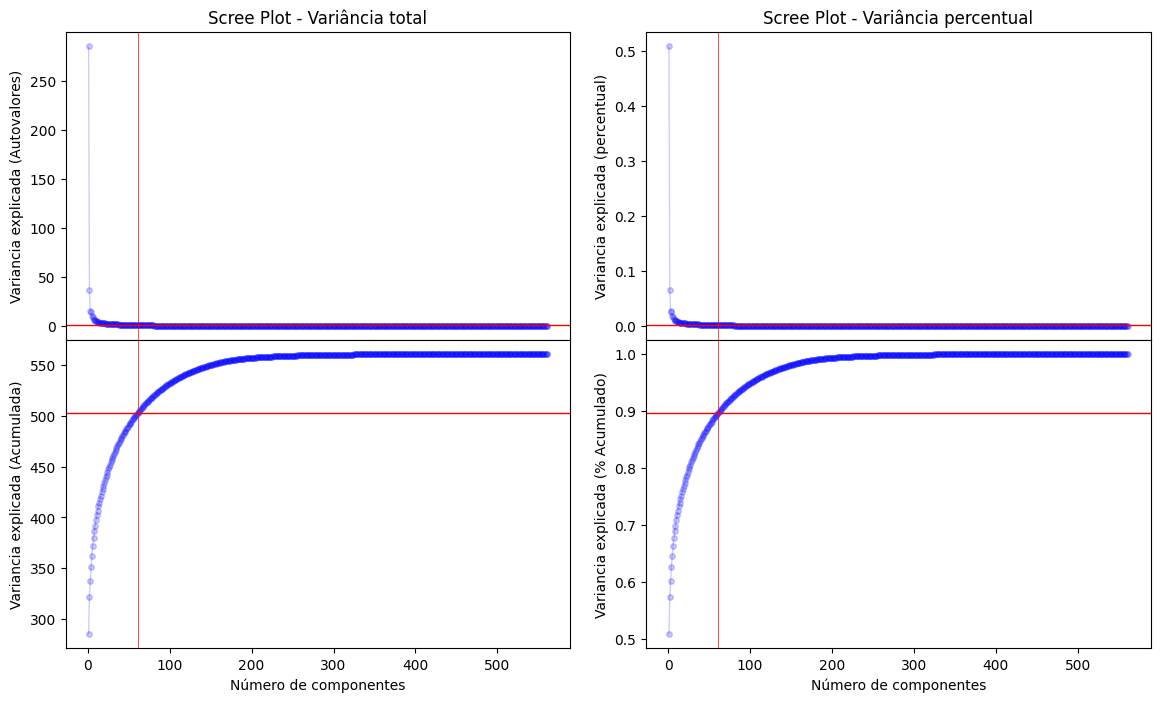

In [47]:
ncomp_criterio1 = (prcomp.explained_variance_ratio_>1/prcomp.n_components_).sum()

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

ampli_y1 = prcomp.explained_variance_[0]

num_componentes = np.arange(prcomp.n_components_) + 1
ax[0,0].plot(num_componentes, prcomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=4, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

ax[1,0].plot(num_componentes, prcomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=4, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')


ampli_y2 = prcomp.explained_variance_ratio_[0]
# ax[1].set_ylim(-ampli_y2*.05, ampli_y2*1.1)

ax[0,1].plot(num_componentes, prcomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=4, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

ax[1,1].plot(num_componentes, prcomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=4, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# Linhas verticais de referência
ax[0,0].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)


# linhas horizontais
ax[0,0].axhline(y = prcomp.explained_variance_[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=1)
ax[1,0].axhline(y = prcomp.explained_variance_.cumsum()[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=1)
ax[0,1].axhline(y = prcomp.explained_variance_ratio_[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=1)
ax[1,1].axhline(y = prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=1)

plt.show()

In [134]:
print('Para atingir {:.2f} é necessário utilizar {} N_componentes'.format(explained_variance_cumsum[components_90-1]  , ncomp_criterio1))

Para atingir 0.90 é necessário utilizar 61 N_componentes


## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

#### Árvore sem dados padronizados

In [122]:
%%time
clf = DecisionTreeClassifier(random_state= 21 , ccp_alpha= 0.001).fit(X_train , y_train)

CPU times: total: 5.41 s
Wall time: 5.68 s


In [123]:
%%time

prcomp = PCA(n_components= 10).fit(X_train)
pc_train = prcomp.transform(X_train)
pc_test = prcomp.transform(X_test)

CPU times: total: 297 ms
Wall time: 195 ms


In [125]:
%%time
clf.fit(pc_train , y_train)
train_acc = clf.score(pc_train , y_train)
test_acc = clf.score(pc_test , y_test)

print('Acurácia na base de treino {:.1f}'.format(train_acc * 100))
print('Acurácia na base de teste {:.1f}'.format(test_acc * 100))

Acurácia na base de treino 89.3
Acurácia na base de teste 82.4
CPU times: total: 78.1 ms
Wall time: 80.2 ms


#### Árvore com dados padronizados

In [128]:
X_test_pad = pd.DataFrame(X_test).apply(padroniza, axis=0)

In [127]:
%%time
clf = DecisionTreeClassifier(random_state= 21 , ccp_alpha= 0.001).fit(X_train_pad , y_train)

In [130]:
%%time

prcomp = PCA(n_components= 10).fit(X_train_pad)
pc_train_pad = prcomp.transform(X_train_pad)
pc_test_pad = prcomp.transform(X_test_pad)

In [132]:
%%time

clf.fit(pc_train_pad , y_train)
train_acc_pad = clf.score(pc_train_pad , y_train)
test_acc_pad = clf.score(pc_test_pad , y_test)

print('Acurácia na base de treino padronizada {:.1f}'.format(train_acc_pad * 100))
print('Acurácia na base de teste padronizada {:.1f}'.format(test_acc_pad * 100))

Acurácia na base de treino 85.9
Acurácia na base de teste 77.4
CPU times: total: 109 ms
Wall time: 107 ms
